# Случайные леса
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать ансамбль деревьев решений, известный как случайный лес, применить его к публичным данным и сравнить его эффективность с ансамблями из самых популярных библиотек.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
from tqdm import tqdm
from tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from scipy import stats
from hyperopt import fmin, hp, Trials, anneal
from sklearn.model_selection import cross_val_score, StratifiedKFold
import multiprocessing as mp
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, \
                            precision_recall_curve, classification_report


SEED = 19

### Задание 1 (3 балла)
Реализуем сам Random Forest. Идея очень простая: строим `n` деревьев, а затем берем модальное предсказание. Используйте реализацию дерева из HW3.

#### Параметры конструктора
`n_estimators` - количество используемых для предсказания деревьев.

Остальное - параметры деревьев.

#### Методы
`fit(X, y)` - строит `n_estimators` деревьев по выборке `X`.

`predict(X)` - для каждого элемента выборки `X` возвращает самый частый класс, который предсказывают для него деревья.

In [2]:
# случайная функция, которая выдает в среднем корень из общего числа признаков
def subspace_fn(n):
    return int(np.sqrt(n)) + np.random.binomial(1, np.sqrt(n) - int(np.sqrt(n)))

In [3]:
# основная рабочая функция, которую будем параллелить
def tree_planting(params):
    # входные параметры
    (X, y), tree_params, score_fn, subspace = params

    # бутстреп сэмплинг
    idxs = np.random.choice(X.index, size=len(X))
    X_sampled = X.loc[idxs, :].reset_index(drop=True)
    y_sampled = y.loc[idxs].reset_index(drop=True)

    # обучаем дерево на случайных подпространствах
    tree = DecisionTreeClassifier(**tree_params)
    tree.fit(X_sampled, y_sampled, subspace=subspace)

    # оцениваем ошибку out-of-bag
    idxs_out = list(set(X.index) - set(idxs))
    X_oob = X.loc[idxs_out, :]
    y_oob = y.loc[idxs_out]
    oob_score = score_fn(y_oob, tree.predict(X_oob))

    # оцениваем значимость признаков
    score_decreases = []
    for col in X_oob.columns:
        X_shuffled = X_oob.copy()
        shuffle_idxs = np.random.choice(X_oob.index, len(X_oob), replace=False)
        X_shuffled[col] = X[col][shuffle_idxs].values
        oob_score_shuffled = score_fn(y_oob, tree.predict(X_shuffled))
        score_decreases.append(oob_score - oob_score_shuffled)

    return tree, oob_score, score_decreases

In [4]:
# функция предсказания, которую тоже будем параллелить
def predict_fn(params):
    X, tree = params
    return tree.predict(X)

In [5]:
class RandomForestClassifier:
    
    def __init__(self, criterion="gini", max_depth=None, min_samples_leaf=1, 
                 max_features="auto", n_estimators=10, score_fn=accuracy_score, verbose=True):
        assert criterion in ["gini", "entropy"]
        assert max_depth is None or max_depth > 0 and int(max_depth) == max_depth
        assert min_samples_leaf > 0 and int(min_samples_leaf) == min_samples_leaf
        assert max_features == "auto" or max_depth > 0 and int(max_depth) == max_depth
        assert n_estimators > 0 and int(n_estimators) == n_estimators
        self.tree_params = {
            "criterion": criterion,
            "max_depth": max_depth,
            "min_samples_leaf": min_samples_leaf
        }
        self.max_features = max_features
        self.n_estimators = n_estimators
        self.trees = []
        self.oob = []
        self.score_fn = score_fn
        self.feature_importance = []
        self.verbose = verbose
        self.result = None
    
    def fit(self, X, y):
        
        subspace = subspace_fn if self.max_features == "auto" else self.max_features
        
        # параллельное построение деревьев
        params = ((X, y), self.tree_params, self.score_fn, subspace)
        pool = mp.Pool(mp.cpu_count())
        results = pool.map(tree_planting, (params for i in range(self.n_estimators)))
        pool.close()
        pool.join()
        
        # структурируем результаты
        self.feature_importance = []
        for result in results:
            self.trees.append(result[0])
            self.oob.append(result[1])
            self.feature_importance.append(result[2])
        self.feature_importance = pd.Series(data=np.array(self.feature_importance).mean(axis=0), index=X.columns)
                
            
    def predict(self, X):
        pool = mp.Pool(mp.cpu_count())
        votes = pool.map(predict_fn, ((X, tree) for tree in self.trees))
        pool.close()
        pool.join()
        votes = pd.concat(votes, axis=1).values
        y_pred = stats.mode(votes, axis=1)[0].reshape(1, -1)[0]
        return y_pred

### Задание 3 (2 балла)
Оптимизируйте по `AUC` на кроссвалидации (размер валидационной выборки - 20%) параметры своей реализации `Random Forest`: 

максимальную глубину деревьев из [2, 3, 5, 7, 10], количество деревьев из [5, 10, 20, 30, 50, 100]. 

Постройте `ROC` кривую (и выведите `AUC` и `accuracy`) для лучшего варианта.

Подсказка: можно построить сразу 100 деревьев глубины 10, а потом убирать деревья и
глубину.

In [6]:
def find_best_rf_params(X, y, n_splits, space, max_evals):
    
    space_hp = {
        "max_depth": hp.choice("max_depth", space["max_depth"]),
        "n_estimators": hp.choice("n_estimators", space["n_estimators"])
    }
    
    def cross_val_loss(params, X=X, y=y, n_splits=n_splits):
        params["n_estimators"] = int(params["n_estimators"])
        params["max_depth"] = int(params["max_depth"])
        model = RandomForestClassifier(**params)
        skf = StratifiedKFold(n_splits=n_splits)
        scores = []
        for train_index, val_index in skf.split(X, y):
            X_t, X_v = X.iloc[train_index, :], X.iloc[val_index, :]
            y_t, y_v = y.iloc[train_index], y.iloc[val_index]
            model.fit(X_t, y_t)
            y_p = model.predict(X_v)
            scores.append(accuracy_score(y_v, y_p))
        return -np.mean(scores)
    
    best = fmin(cross_val_loss, space_hp, anneal.suggest, max_evals=max_evals, rstate=np.random.RandomState(SEED))
    best_values = {param: space[param][best[param]] for param in space.keys()}
    return best_values

In [7]:
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return pd.DataFrame(np.array(X)), pd.Series(np.array(y))

X, y = synthetic_dataset(1000)

In [8]:
space = {
    "max_depth": [2, 3, 5, 7, 10],
    "n_estimators": [5, 10, 20, 30, 50]
}

best_params = find_best_rf_params(X, y, n_splits=3, space=space, max_evals=5)

100%|██████████| 5/5 [03:42<00:00, 44.56s/trial, best loss: -1.0]               


In [9]:
best_params

{'max_depth': 10, 'n_estimators': 10}

### Задание 4 (3 балла)
Часто хочется понимать, насколько большую роль играет тот или иной признак для предсказания класса объекта. Есть различные способы посчитать его важность. Один из простых способов сделать это для Random Forest выглядит так:
1. Посчитать out-of-bag ошибку предсказания `err_oob` (https://en.wikipedia.org/wiki/Out-of-bag_error)
2. Перемешать значения признака `j` у объектов выборки (у каждого из объектов изменится значение признака `j` на какой-то другой)
3. Посчитать out-of-bag ошибку (`err_oob_j`) еще раз.
4. Оценкой важности признака `j` для одного дерева будет разность `err_oob_j - err_oob`, важность для всего леса считается как среднее значение важности по деревьям.

Реализуйте функцию `feature_importance`, которая принимает на вход Random Forest и возвращает массив, в котором содержится важность для каждого признака.

In [10]:
def feature_importance(rfc):
    raise NotImplementedError()

def most_important_features(importance, names, k=20):
    # Выводит названия k самых важных признаков
    idicies = np.argsort(importance)[::-1][:k]
    return np.array(names)[idicies]

Протестируйте решение на простом синтетическом наборе данных. В результате должна получиться точность `1.0`, наибольшее значение важности должно быть у признака с индексом `4`, признаки с индексами `2` и `3`  должны быть одинаково важны, а остальные признаки - не важны совсем.

In [11]:
%%time
def synthetic_dataset(size):
    X = [(np.random.randint(0, 2), np.random.randint(0, 2), i % 6 == 3, 
          i % 6 == 0, i % 3 == 2, np.random.randint(0, 2)) for i in range(size)]
    y = [i % 3 for i in range(size)]
    return pd.DataFrame(np.array(X)), pd.Series(np.array(y))

X, y = synthetic_dataset(1000)
rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X, y)

CPU times: user 265 ms, sys: 72.7 ms, total: 337 ms
Wall time: 45.5 s


In [12]:
print("Accuracy:", np.mean(rfc.predict(X) == y))
print(f"Importance:\n{rfc.feature_importance}")

Accuracy: 0.982
Importance:
0   -0.001201
1   -0.001436
2    0.161363
3    0.170365
4    0.330237
5   -0.001674
dtype: float64


Проверьте, какие признаки важны для датасетов cancer и spam?

In [13]:
home_path = os.getcwd()
CANCER_DATA_PATH = os.path.join(home_path, "hw2_data", "cancer.csv")
SPAM_DATA_PATH = os.path.join(home_path, "hw2_data", "spam.csv")

In [14]:
def read_cancer_dataset(path_to_csv):
    df = pd.read_csv(path_to_csv)
    X, y = df.drop("label", axis=1), df.label
    return X, y

def read_spam_dataset(path_to_csv):
    return read_cancer_dataset(path_to_csv)

In [15]:
X_cancer, y_cancer = read_cancer_dataset(CANCER_DATA_PATH)
y_cancer = y_cancer.map({"M": 0, "B": 1})
X_spam, y_spam = read_spam_dataset(SPAM_DATA_PATH)

# Cancer

In [16]:
np.random.seed(SEED)
X_train, X_test, y_train, y_test = train_test_split(X_cancer, y_cancer, test_size=0.2)

In [17]:
%%time
rfc = RandomForestClassifier(n_estimators=20)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

CPU times: user 281 ms, sys: 101 ms, total: 381 ms
Wall time: 20.9 s


In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.89      0.91        45
           1       0.93      0.96      0.94        69

    accuracy                           0.93       114
   macro avg       0.93      0.92      0.93       114
weighted avg       0.93      0.93      0.93       114



# Spam

In [19]:
np.random.seed(SEED)
X_train, X_test, y_train, y_test = train_test_split(X_spam, y_spam, test_size=0.2)

In [20]:
%%time
rfc = RandomForestClassifier(n_estimators=20)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

CPU times: user 4.15 s, sys: 436 ms, total: 4.59 s
Wall time: 3min 40s


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       550
           1       0.88      0.80      0.84       371

    accuracy                           0.88       921
   macro avg       0.88      0.86      0.87       921
weighted avg       0.88      0.88      0.88       921



Random forest демонстрирует хорошее качество

### Задание 5 (2 балла)
В качестве альтернативы попробуем библиотечные реализации ансамблей моделей. 

1. [CatBoost](https://catboost.ai/docs/)
2. [XGBoost](https://xgboost.readthedocs.io/en/latest/)
3. [LightGBM](https://lightgbm.readthedocs.io/en/latest/)


Установите необходимые библиотеки. 
Возможно, потребуется установка дополнительных пакетов

In [22]:
!pip install -U --user lightgbm
!pip install -U --user catboost
!pip install -U --user xgboost

Requirement already up-to-date: lightgbm in /Users/a18264698/.local/lib/python3.7/site-packages (3.2.0)
Requirement already up-to-date: catboost in /Users/a18264698/.local/lib/python3.7/site-packages (0.24.4)
Requirement already up-to-date: xgboost in /Users/a18264698/.local/lib/python3.7/site-packages (1.3.3)


Также, как и реализованный нами RandomForest, примените модели для наших датасетов.

Для стандартного набора параметров у каждой модели нарисуйте `ROC` кривую и выведите `AUC` и `accuracy`.

Посчитайте время обучения каждой модели (можно использовать [timeit magic](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit)). 

Сравните метрики качества и скорость обучения моделей. Какие выводы можно сделать?

In [23]:
def make_classification_report(y_true, y_pred, y_proba):
    print(classification_report(y_true, y_pred))

    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    fpr, tpr, thresholds = roc_curve(y_true, y_proba)
    roc_score = roc_auc_score(y_true, y_proba)
    ax[0].set_title(f"ROC curve (AUC: {roc_score:.4f})", fontsize=15)
    ax[0].grid()
    ax[0].plot(fpr, tpr)

    fpr, tpr, thresholds = precision_recall_curve(y_true, y_proba)
    ap_score = average_precision_score(y_true, y_proba)
    ax[1].set_title(f"PR curve (AUC: {ap_score:.4f})", fontsize=15)
    ax[1].grid()
    ax[1].plot(fpr, tpr);

In [24]:
np.random.seed(SEED)
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cancer, y_cancer, test_size=0.2)

In [25]:
np.random.seed(SEED)
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_spam, y_spam, test_size=0.2)

## CatBoost

In [26]:
from catboost import CatBoostClassifier

In [27]:
%%time
cb_model = CatBoostClassifier(iterations=100, eval_metric="AUC", verbose=False)
cb_model.fit(X_train_c, y_train_c)
y_pred_c = cb_model.predict_proba(X_test_c)[:, 1]

CPU times: user 2.05 s, sys: 127 ms, total: 2.18 s
Wall time: 329 ms


              precision    recall  f1-score   support

           0       1.00      0.91      0.95        45
           1       0.95      1.00      0.97        69

    accuracy                           0.96       114
   macro avg       0.97      0.96      0.96       114
weighted avg       0.97      0.96      0.96       114



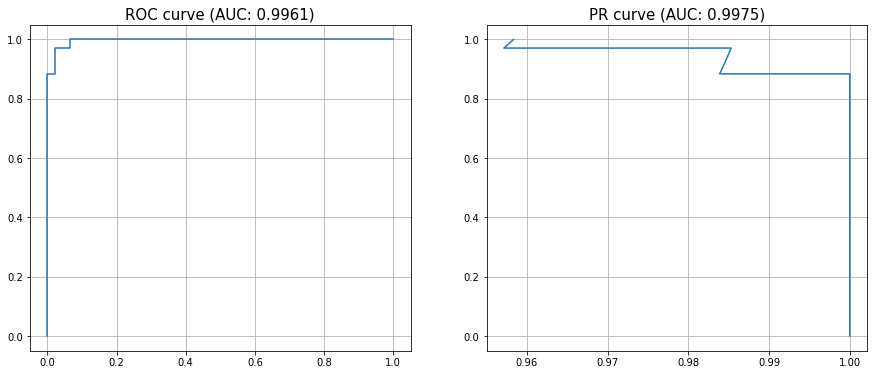

In [28]:
make_classification_report(y_test_c, np.round(y_pred_c), y_pred_c)

In [29]:
%%time
cb_model.fit(X_train_s, y_train_s)
y_pred_s = cb_model.predict_proba(X_test_s)[:, 1]

CPU times: user 3.74 s, sys: 229 ms, total: 3.97 s
Wall time: 528 ms


              precision    recall  f1-score   support

           0       0.94      0.98      0.96       550
           1       0.97      0.91      0.94       371

    accuracy                           0.95       921
   macro avg       0.95      0.94      0.95       921
weighted avg       0.95      0.95      0.95       921



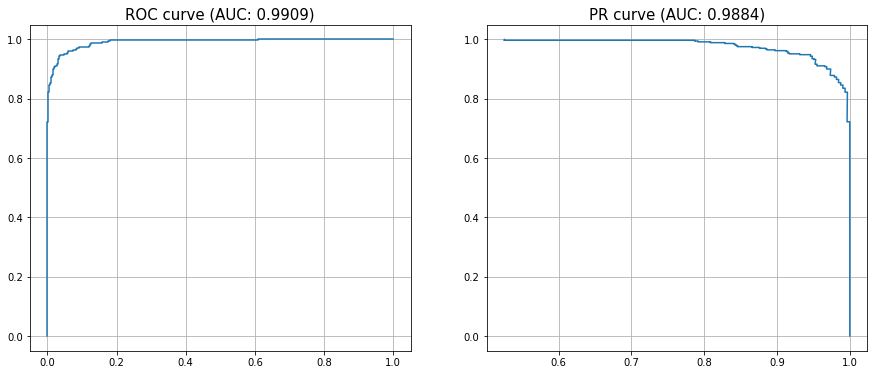

In [30]:
make_classification_report(y_test_s, np.round(y_pred_s), y_pred_s)

## LightGBM

In [31]:
from lightgbm import LGBMClassifier

In [32]:
%time
lgb_model = LGBMClassifier(n_estimators=100)
lgb_model.fit(X_train_c, y_train_c)
y_pred_c = lgb_model.predict_proba(X_test_c)[:, 1]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 3.81 µs


              precision    recall  f1-score   support

           0       0.98      0.91      0.94        45
           1       0.94      0.99      0.96        69

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



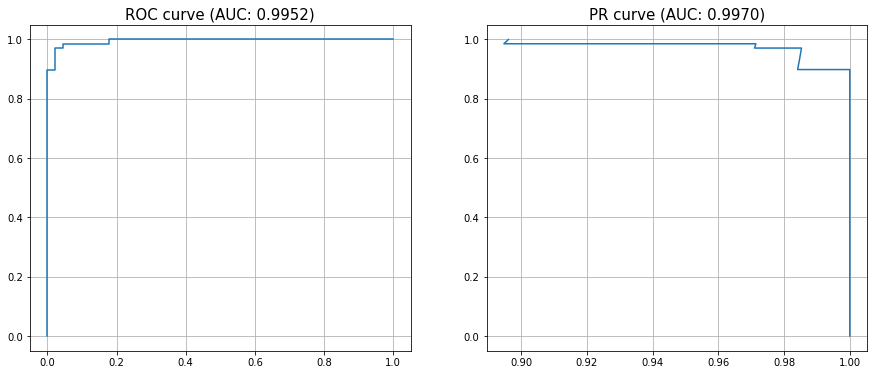

In [33]:
make_classification_report(y_test_c, np.round(y_pred_c), y_pred_c)

In [34]:
%time
lgb_model.fit(X_train_s.values, y_train_s.values)
y_pred_s = lgb_model.predict_proba(X_test_s)[:, 1]

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 5.25 µs


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       550
           1       0.95      0.94      0.94       371

    accuracy                           0.95       921
   macro avg       0.95      0.95      0.95       921
weighted avg       0.95      0.95      0.95       921



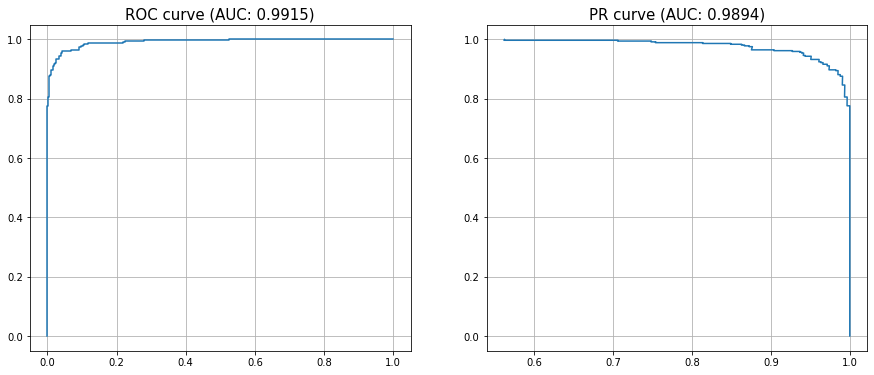

In [35]:
make_classification_report(y_test_s, np.round(y_pred_s), y_pred_s)

## XGBoost

In [36]:
from xgboost import XGBClassifier

In [41]:
%%time
xgb_model = XGBClassifier(n_estimators=100)
xgb_model.fit(X_train_c, y_train_c)
y_pred_c = xgb_model.predict_proba(X_test_c)[:, 1]

[14:08:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 863 ms, sys: 59 ms, total: 922 ms
Wall time: 104 ms


              precision    recall  f1-score   support

           0       0.98      0.91      0.94        45
           1       0.94      0.99      0.96        69

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



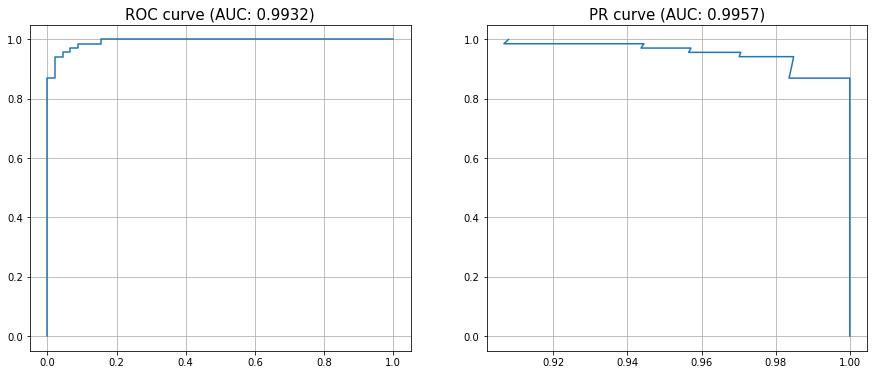

In [42]:
make_classification_report(y_test_c, np.round(y_pred_c), y_pred_c)

In [43]:
%%time
xgb_model.fit(X_train_s.values, y_train_s.values)
y_pred_s = xgb_model.predict_proba(X_test_s.values)[:, 1]

[14:08:26] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: user 3.28 s, sys: 91.5 ms, total: 3.37 s
Wall time: 331 ms


              precision    recall  f1-score   support

           0       0.95      0.97      0.96       550
           1       0.96      0.92      0.94       371

    accuracy                           0.95       921
   macro avg       0.95      0.95      0.95       921
weighted avg       0.95      0.95      0.95       921



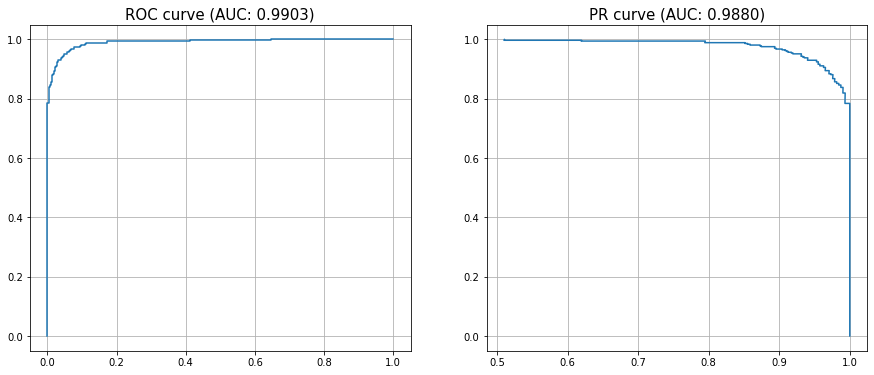

In [44]:
make_classification_report(y_test_s, np.round(y_pred_s), y_pred_s)

# Discussion

Библиотечные реализации бустинга ожидаемо выигрывают по скорости и качеству перед нашей кустарной реализацией, так как кроме более продвинутого алгоритма они содержат множество различных эвристик, позволяющих значительно сократить время обучения модели